In [1]:
%pylab inline
import seaborn as sns
import pandas as pd
import time
import scipy
import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# still working on this
# from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('white')
pd.set_option('display.max_columns', 35)
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['axes.titlesize']=16

%config InlineBackend.figure_format='retina'

# Reading in Data

In [3]:
print "Starting to read in data..."
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

Starting to read in data...
Read in data in 7.37 seconds.


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)
    
# adding the derived columns
requests['ACTUAL_LAG'] = requests['CLOSED_DT'] - requests['OPEN_DT']
requests['EXPECTED_LAG'] = requests['TARGET_DT'] - requests['OPEN_DT']
t2= time.time()

print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 287.11 seconds.


# Descriptive Tables and Columns

In [5]:
requests.describe()

,CASE_ENQUIRY_ID,fire_district,city_council_district,neighborhood_services_district,LOCATION_ZIPCODE,Property_ID,LATITUDE,LONGITUDE,ACTUAL_LAG,EXPECTED_LAG
count,7.414790e+05,705302.000000,708094.000000,708093.000000,569199.000000,708248.000000,741479.000000,741479.000000,682985,568702
mean,1.010010e+11,7.245801,4.675104,8.972152,2127.478086,100775.067798,42.324841,-71.085479,23 days 04:27:55.134265,62 days 15:05:39.413056
std,4.359690e+05,3.280281,2.550621,4.172519,17.785509,95373.252851,0.035126,0.036447,84 days 10:41:47.688509,385 days 12:40:24.691772
min,1.010003e+11,1.000000,0.000000,0.000000,2026.000000,1.000000,42.232100,-71.185400,-1 days +23:59:02,-228 days +19:09:25
25%,1.010007e+11,4.000000,2.000000,6.000000,2121.000000,16592.750000,42.293800,-71.111700,0 days 01:47:58,2 days 00:00:00
50%,1.010011e+11,7.000000,5.000000,10.000000,2126.000000,82519.000000,42.331400,-71.075900,1 days 18:25:15,4 days 00:12:04
75%,1.010014e+11,9.000000,7.000000,13.000000,2131.000000,145504.000000,42.355800,-71.058700,8 days 05:46:49,28 days 00:00:00
max,1.010018e+11,12.000000,9.000000,15.000000,2467.000000,419841.000000,42.395200,-70.994900,1637 days 03:24:20,17963 days 18:45:06


In [6]:
requests.head()

,CASE_ENQUIRY_ID,OPEN_DT,TARGET_DT,CLOSED_DT,OnTime_Status,CASE_STATUS,CLOSURE_REASON,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,SubmittedPhoto,ClosedPhoto,Location,fire_district,pwd_district,city_council_district,police_district,neighborhood,neighborhood_services_district,ward,precinct,land_usage,LOCATION_STREET_NAME,LOCATION_ZIPCODE,Property_Type,Property_ID,LATITUDE,LONGITUDE,Source,Geocoded_Location,ACTUAL_LAG,EXPECTED_LAG
0,101000295613,2011-07-01 01:32:33,2011-07-15 01:32:32,2011-07-01 05:06:58,ONTIME,Closed,Case Closed Case Resolved replaced 100 amp fus...,Street Light Outages,Public Works Department,Street Lights,Street Light Outages,PWDx_Street Light Outages,PWDx,NaN,NaN,INTERSECTION of Groveland St & River St Matta...,8,07,3,B3,Greater Mattapan,7,Ward 17,1714,NaN,INTERSECTION Groveland St & River St,NaN,Intersection,5512,42.2715,-71.0772,Employee Generated,"(42.2715, -71.0772)",0 days 03:34:25,13 days 23:59:59
1,101000295614,2011-07-01 02:18:31,2011-07-05 02:18:31,2011-07-01 06:12:43,ONTIME,Closed,Case Closed Case Scheduled Items have been sch...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup,PWDx,NaN,NaN,39 Lorraine St Roslindale MA 02131,12,06,5,E5,Roslindale,10,Ward 20,2008,R1,39 Lorraine St,2131,Address,87461,42.2839,-71.1447,Self Service,"(42.2839, -71.1447)",0 days 03:54:12,4 days 00:00:00
2,101000295615,2011-07-01 02:28:04,2011-08-15 02:28:04,2011-08-01 15:21:46,ONTIME,Closed,Case Closed Case Resolved No Sidewalk and poor...,New Sign Crosswalk or Pavement Marking,Transportation - Traffic Division,Signs & Signals,New Sign Crosswalk or Pavement Marking,BTDT_Engineering_New Sign and Pavement Marking...,BTDT,NaN,NaN,INTERSECTION of Corey St & Lagrange St West R...,NaN,06,6,E5,West Roxbury,12,Ward 20,2017,NaN,INTERSECTION Corey St & Lagrange St,NaN,Intersection,3522,42.3003,-71.1698,Self Service,"(42.3003, -71.1698)",31 days 12:53:42,45 days 00:00:00
3,101000295616,2011-07-01 03:03:48,2011-07-15 03:03:48,2011-07-22 16:13:45,OVERDUE,Closed,Case Closed Case Resolved completed,Street Light Outages,Public Works Department,Street Lights,Street Light Outages,PWDx_Street Light_Pending_Contractor (Internal),PWDx,NaN,NaN,235 Fairmount Ave Hyde Park MA 02136,12,08,5,E18,Hyde Park,10,Ward 18,1816,R2,235 Fairmount Ave,2136,Address,55708,42.2496,-71.1156,Self Service,"(42.2496, -71.1156)",21 days 13:09:57,14 days 00:00:00
4,101000295617,2011-07-01 03:12:31,NaT,2011-07-01 06:12:38,ONTIME,Closed,Case Closed Case Resolved,Highway Maintenance,Public Works Department,Highway Maintenance,Highway Maintenance,PWDx_District 03: North Dorchester,PWDx,NaN,NaN,INTERSECTION of Dorchester Ave & Hallam St Do...,7,03,3,C11,Dorchester,7,Ward 13,1309,NaN,INTERSECTION Dorchester Ave & Hallam St,NaN,Intersection,4182,42.3144,-71.0569,Constituent Call,"(42.3144, -71.0569)",0 days 03:00:07,NaT


In [7]:
requests.dtypes

CASE_ENQUIRY_ID                             int64
OPEN_DT                            datetime64[ns]
TARGET_DT                          datetime64[ns]
CLOSED_DT                          datetime64[ns]
OnTime_Status                              object
CASE_STATUS                                object
CLOSURE_REASON                             object
CASE_TITLE                                 object
SUBJECT                                    object
REASON                                     object
TYPE                                       object
QUEUE                                      object
Department                                 object
SubmittedPhoto                             object
ClosedPhoto                                object
Location                                   object
fire_district                             float64
pwd_district                               object
city_council_district                     float64
police_district                            object


# Useful Data Slices

In [8]:
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']

In [9]:
open_requests = requests[requests['CASE_STATUS'] == 'Open']

In [171]:
closed_clean = closed_requests[(closed_requests['Source'] == 'Citizens Connect App') |\
                               (closed_requests['Source'] == 'Constituent Call')] 

app = closed_clean[closed_clean['Source'] == 'Citizens Connect App']
calls = closed_clean[closed_clean['Source'] == 'Constituent Call']

In [11]:
begin = pd.to_datetime('January 1, 2015 12:00PM')
end = pd.to_datetime('January 1, 2016 12:00PM')

in_range = closed_clean[requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


# Useful Plots

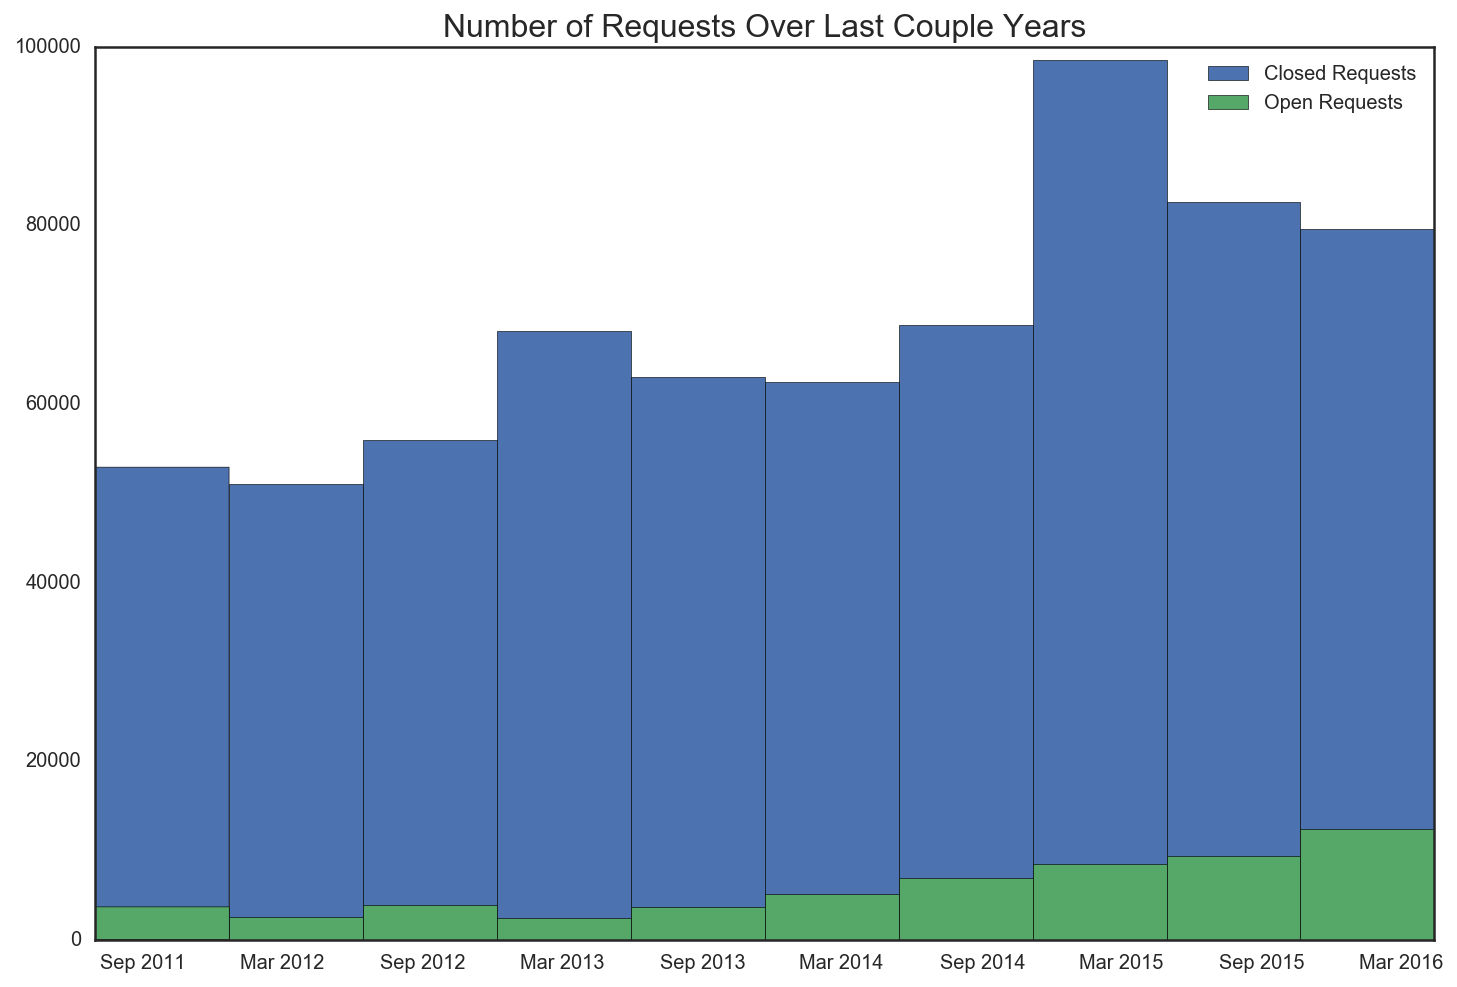

In [12]:
plt.title("Number of Requests Over Last Couple Years")
plt.hist(closed_requests['OPEN_DT'].values, label='Closed Requests')
plt.hist(open_requests['OPEN_DT'].values, label='Open Requests')
plt.legend()

(array([ 63178.,  12360.,   3835.,   2414.,   1699.,   1279.,   1051.,
           945.,    699.,    577.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

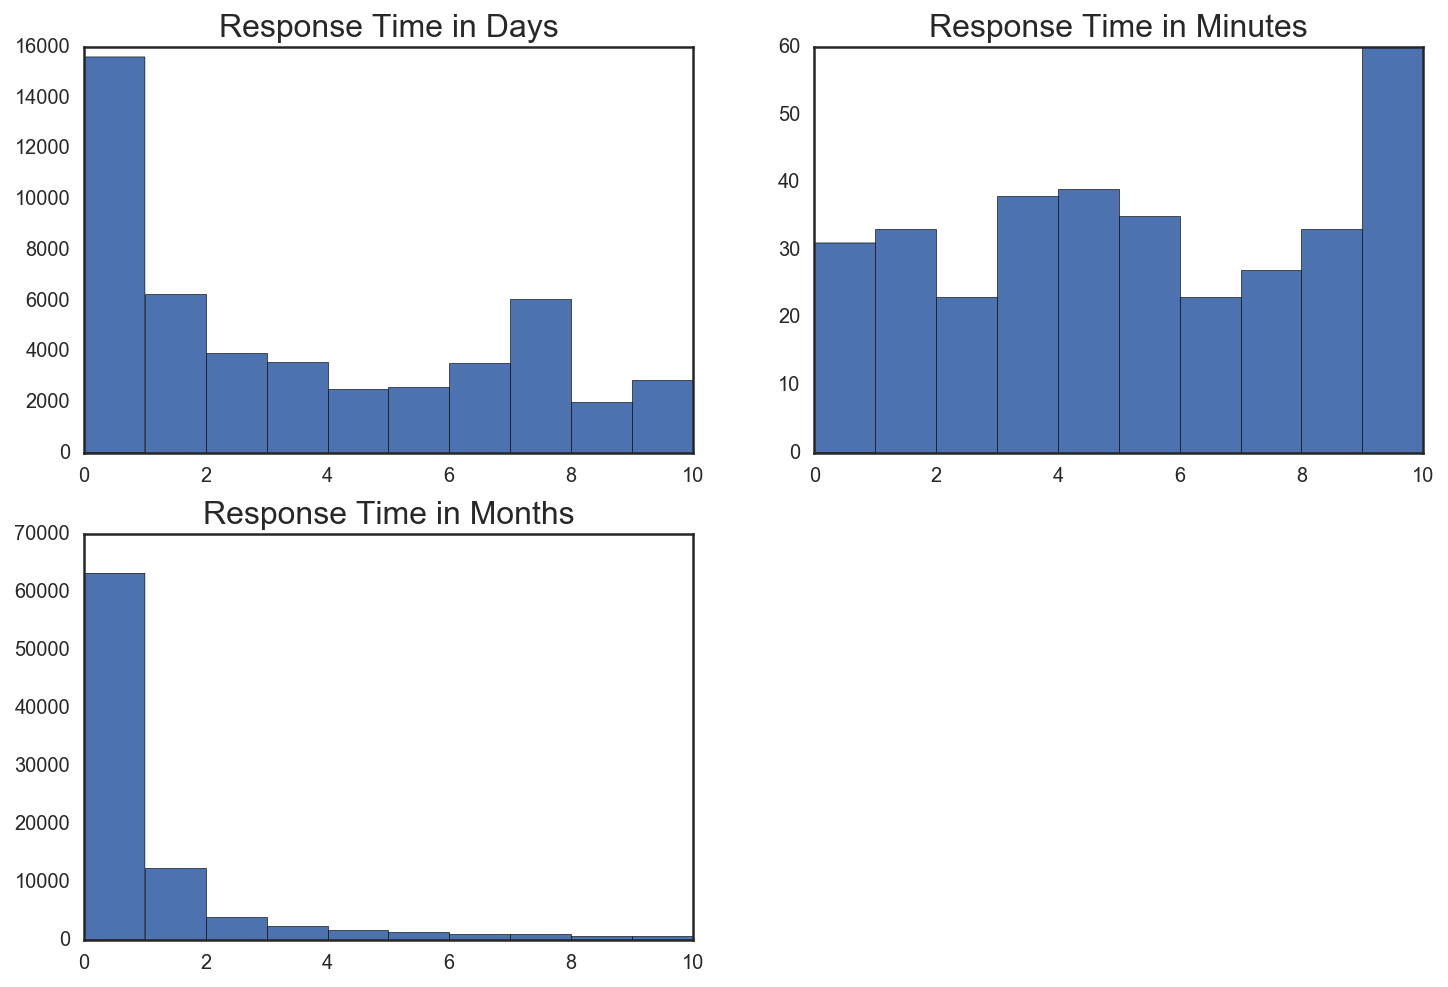

In [13]:
delays = closed_clean['CLOSED_DT'] - closed_clean['TARGET_DT']

plt.subplot(221)
plt.title('Response Time in Days')
plt.hist(delays.astype('timedelta64[D]'), range=(0,10))
plt.subplot(222)
plt.title('Response Time in Minutes')
plt.hist(delays.astype('timedelta64[m]'), range=(0,10))
plt.subplot(223)
plt.title("Response Time in Months")
plt.hist(delays.astype('timedelta64[D]')/31, range=(0,10))

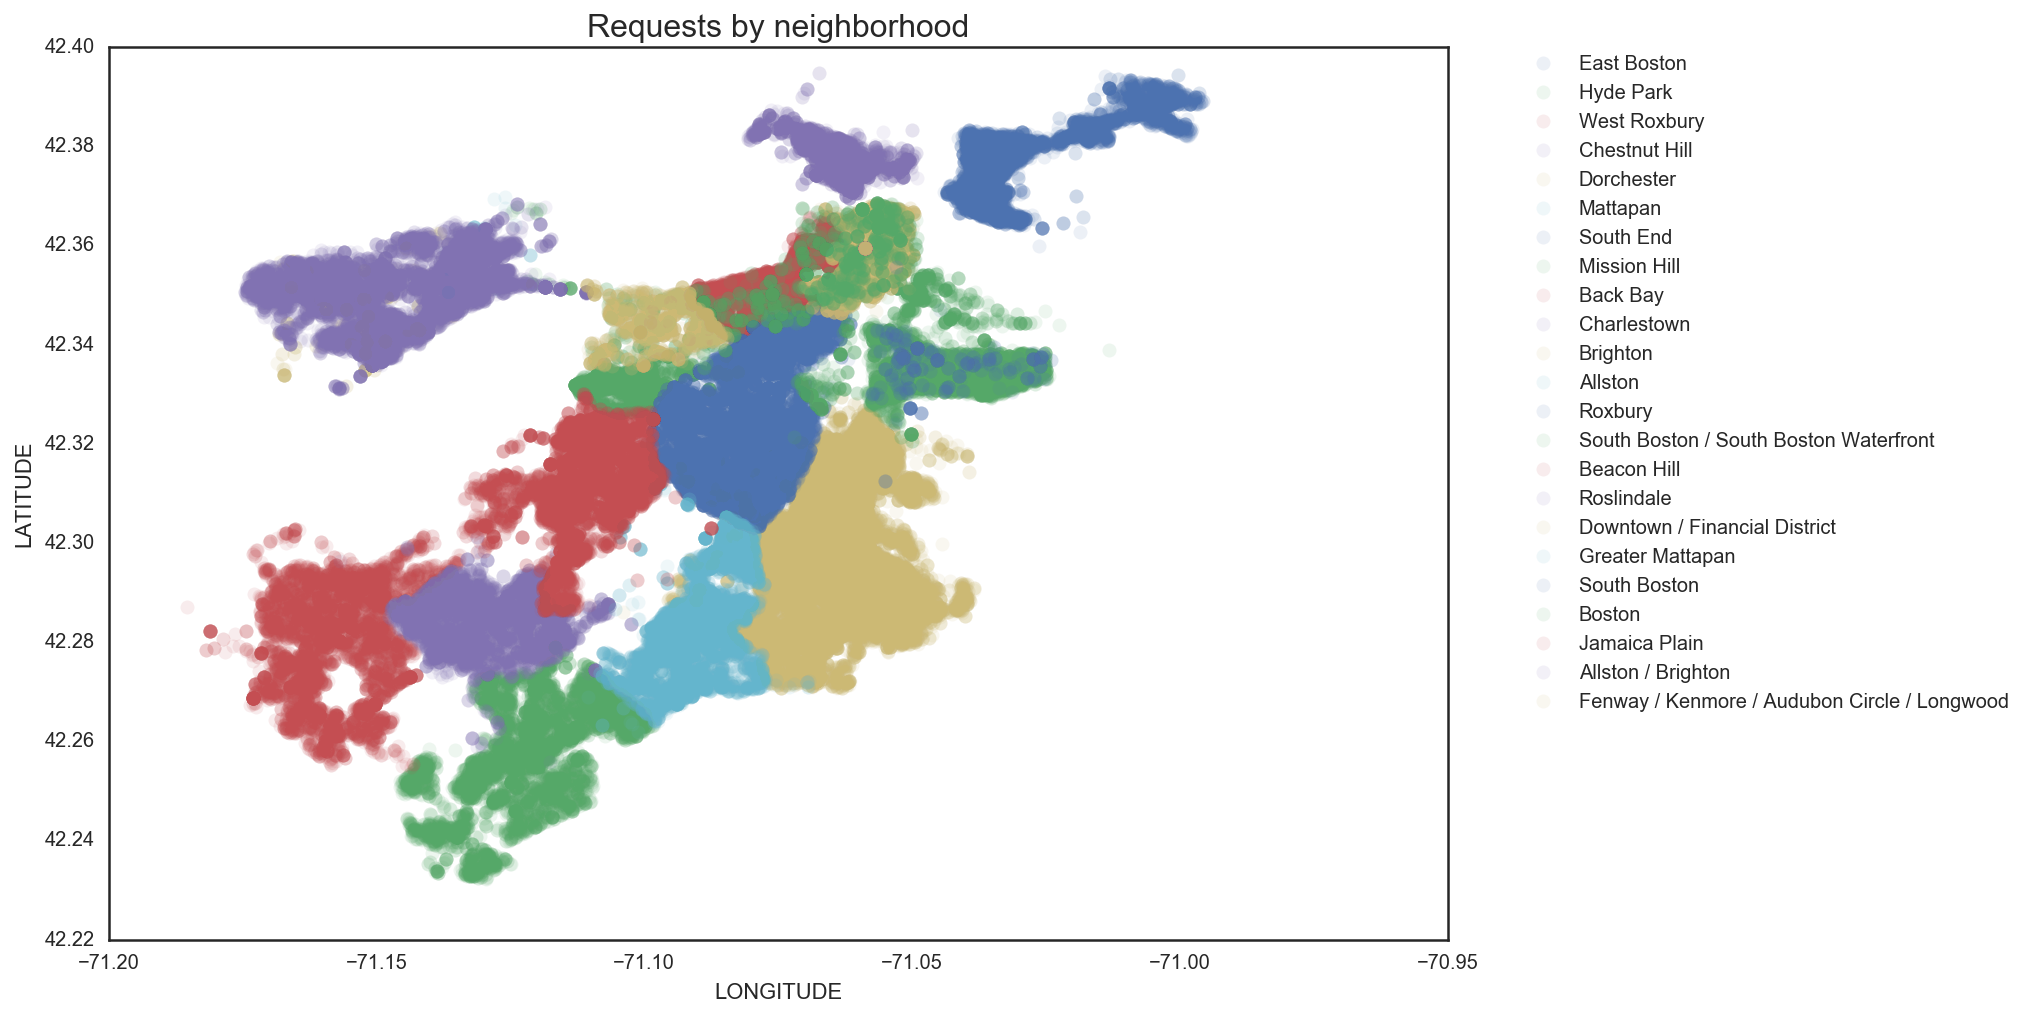

In [14]:
def plot_by(in_range, col_name='neighborhood', x='LONGITUDE', y='LATITUDE'):
    plt.title('Requests by ' + col_name)
    for name in set(in_range[col_name]) - set([np.nan]):
        attr = in_range[in_range[col_name] == name]
        plt.plot(attr[x], attr[y], 'o', alpha=.1, label=name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_by(in_range)

138919


,CASE_ENQUIRY_ID,OPEN_DT,TARGET_DT,CLOSED_DT,OnTime_Status,CASE_STATUS,CLOSURE_REASON,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,SubmittedPhoto,ClosedPhoto,Location,fire_district,pwd_district,city_council_district,police_district,neighborhood,neighborhood_services_district,ward,precinct,land_usage,LOCATION_STREET_NAME,LOCATION_ZIPCODE,Property_Type,Property_ID,LATITUDE,LONGITUDE,Source,Geocoded_Location,ACTUAL_LAG,EXPECTED_LAG
501001,101001285702,2015-02-10 13:58:23,2015-02-10 13:58:23,2015-08-04 11:22:45,OVERDUE,Closed,Case Closed. Closed date : 2015-08-04 11:22:45...,Catchbasin,Boston Water & Sewer Commission,Catchbasin,Catchbasin,BWSC_All Cases,BWSC,NaN,NaN,1199 Tremont St Roxbury MA 02118,4,1C,2,D4,South End,6,09,901,CM,1199 Tremont St,2118,Address,170498,42.3341,-71.0908,Constituent Call,"(42.3341, -71.0908)",174 days 21:24:22,00:00:00
505349,101001292240,2015-02-12 19:21:52,2015-02-12 19:21:52,2015-05-27 08:19:54,OVERDUE,Closed,Case Closed. Closed date : 2015-05-27 08:19:54...,Request for Snow Plowing,Public Works Department,Street Cleaning,Request for Snow Plowing,PWDx_District 05: South Boston,PWDx,https://mayors24.cityofboston.gov/media/boston...,NaN,INTERSECTION of L St & Marine Rd South Boston...,6,05,2,C6,South Boston / South Boston Waterfront,5,Ward 7,701,NaN,INTERSECTION L St & Marine Rd,NaN,Intersection,6695,42.3307,-71.0352,Citizens Connect App,"(42.3307, -71.0352)",103 days 12:58:02,00:00:00
540354,101001342349,2015-03-26 09:02:34,2015-03-26 09:02:34,2015-06-15 06:13:15,OVERDUE,Closed,Case Closed. Closed date : 2015-06-15 06:13:15...,Highway Maintenance,Public Works Department,Highway Maintenance,Highway Maintenance,PWDx_Highway Construction,PWDx,NaN,NaN,25 Park St Charlestown MA 02129,3,1A,1,A15,Charlestown,2,Ward 2,201,RC,25 Park St,2129,Address,289681,42.3726,-71.0610,Constituent Call,"(42.3726, -71.061)",80 days 21:10:41,00:00:00
551218,101001357350,2015-04-15 16:44:03,2015-04-15 16:44:03,2015-07-14 08:56:38,OVERDUE,Closed,Case Closed. Closed date : 2015-07-14 08:56:38...,outage////printed,Public Works Department,Street Lights,Street Light Outages,PWDx_Street Light Outages,PWDx,NaN,NaN,INTERSECTION of Brimmer St & Mount Vernon St ...,3,1B,8,A1,Beacon Hill,14,Ward 5,511,NaN,INTERSECTION Brimmer St & Mount Vernon St,NaN,Intersection,1956,42.3574,-71.0720,Constituent Call,"(42.3574, -71.072)",89 days 16:12:35,00:00:00
553714,101001360977,2015-04-21 16:29:11,2015-04-21 16:29:11,2015-08-13 14:57:10,OVERDUE,Closed,Case Closed. Closed date : 2015-08-13 14:57:10...,PRINTED,Public Works Department,Street Lights,Street Light Outages,PWDx_Street Light Outages,PWDx,NaN,NaN,1427-1429 Tremont St Mission Hill MA 02120,9,10A,7,B2,Mission Hill,13,Ward 9,904,RC,1427-1429 Tremont St,2120,Address,136818,42.3319,-71.0963,Constituent Call,"(42.3319, -71.0963)",113 days 22:27:59,00:00:00
556103,101001364362,2015-04-27 09:53:56,2015-04-27 09:53:56,2015-06-05 09:59:20,OVERDUE,Closed,Case Closed. Closed date : 2015-06-05 09:59:20...,New Sign Crosswalk or Pavement Marking,Transportation - Traffic Division,Signs & Signals,New Sign Crosswalk or Pavement Marking,BTDT_Engineering_New Sign and Pavement Marking...,BTDT,NaN,NaN,41 Vassar St Dorchester MA 02121,7,03,4,B3,Dorchester,8,Ward 14,1402,R2,41 Vassar St,2121,Address,139889,42.3000,-71.0782,Constituent Call,"(42.3, -71.0782)",39 days 00:05:24,00:00:00
557306,101001365937,2015-04-28 19:14:45,2015-04-28 19:14:45,2015-05-29 10:55:03,OVERDUE,Closed,Case Closed. Closed date : 2015-05-29 10:55:03...,Graffiti Removal,Property Management,Graffiti,Graffiti Removal,BTDT_Traffic Signal_Repair,BTDT,https://mayors24.cityofboston.gov/media/boston...,NaN,122 Franklin St Allston MA 02134,11,04,9,D14,Allston / Brighton,15,Ward 22,2202,R1,122 Franklin St,2134,Address,60599,42.3604,-71.1327,Citizens Connect App,"(42.3604, -71.1327)",30 days 15:40:18,00:00:00
570929,101001396059,2015-05-27 14:28:00,2015-05-27 14:28:08,2015-08-11 12:20:35,OVERDUE,Closed,Case Closed. Closed date : 2015-08-11 12:20:3

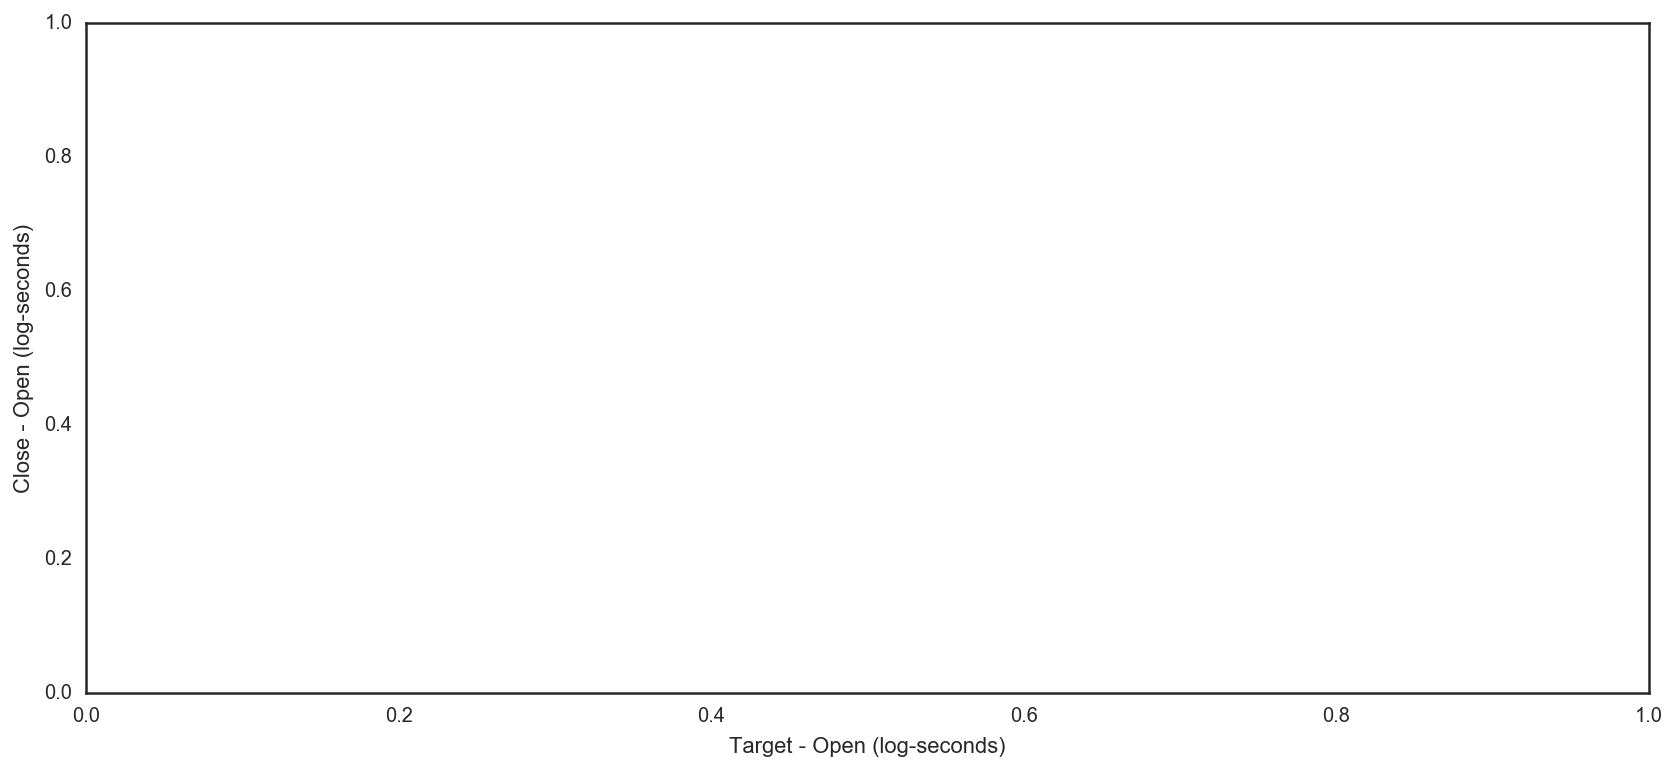

In [15]:
print len(in_range)
plt.figure(figsize=[14,6])
plt.xlabel('Target - Open (log-seconds)')
plt.ylabel('Close - Open (log-seconds)')

tentative = in_range[(in_range['TARGET_DT'] - in_range['OPEN_DT']).astype('timedelta64[s]') < 10]
tentative
#plt.loglog((in_range['TARGET_DT']- in_range['OPEN_DT']).astype('timedelta64[m]'), (in_range['CLOSED_DT'] - in_range['OPEN_DT']).astype('timedelta64[m]'), 'o',alpha=0.05)
#plt.loglog(range(1,10**7,10**5), range(1,10**7,10**5))

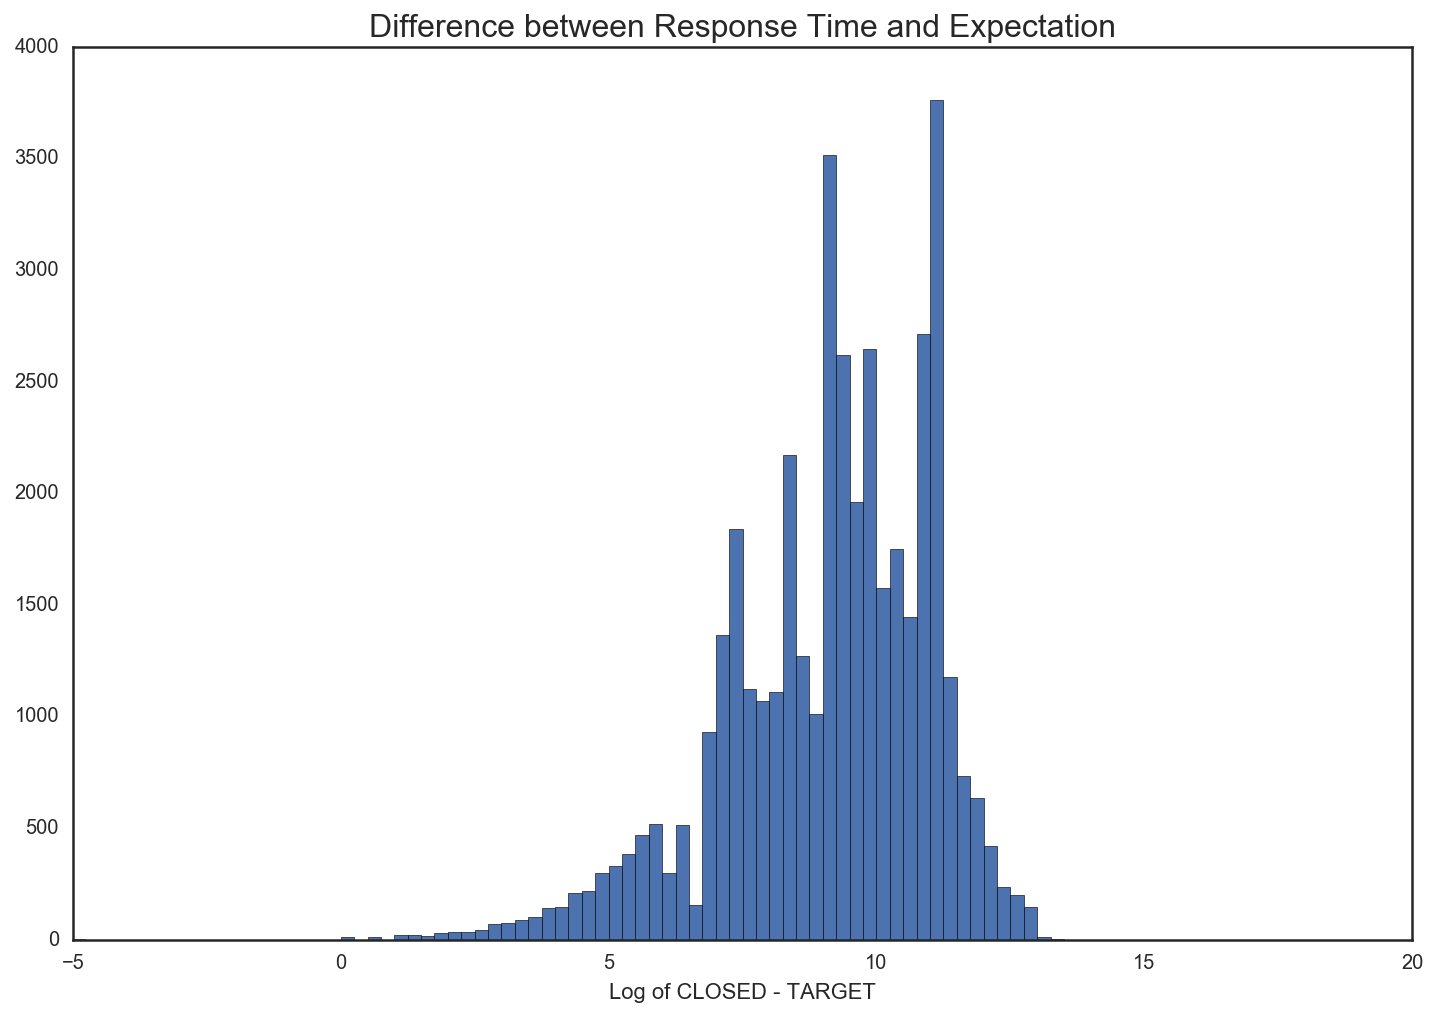

In [16]:
delays = in_range['CLOSED_DT'] - in_range['TARGET_DT']
plt.hist(np.log(delays.astype('timedelta64[m]')), range=(-5,20), bins=100)
plt.title('Difference between Response Time and Expectation')
plt.xlabel('Log of CLOSED - TARGET')

In [117]:
dat = in_range[['LONGITUDE', 'LATITUDE', 'ACTUAL_LAG']]
dat['ACTUAL_LAG'] = dat['ACTUAL_LAG'].astype('timedelta64[m]')
dat = dat.as_matrix()
dat[:,2] = np.log(dat[:,2])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [168]:
subset = dat[:50000]

grid_x, grid_y = np.mgrid[min(subset[:,0]):max(subset[:,0]):100j, 
                          min(subset[:,1]):max(subset[:,1]):100j]

grid_z0 = griddata(subset[:,0:2], subset[:,2], (grid_x, grid_y), method='linear')

In [169]:
mask = np.ones([100,100], dtype=bool)
dx = max(max(subset[:,0])-min(subset[:,0]), max(subset[:,1])-min(subset[:,1]))/100
print dx

for row in subset:
    x,y = row[0], row[1]
    mask[np.logical_and(np.abs(grid_x - x) < dx, np.abs(grid_y - y) < dx)] = False

grid_z0[mask] = -1

0.001853


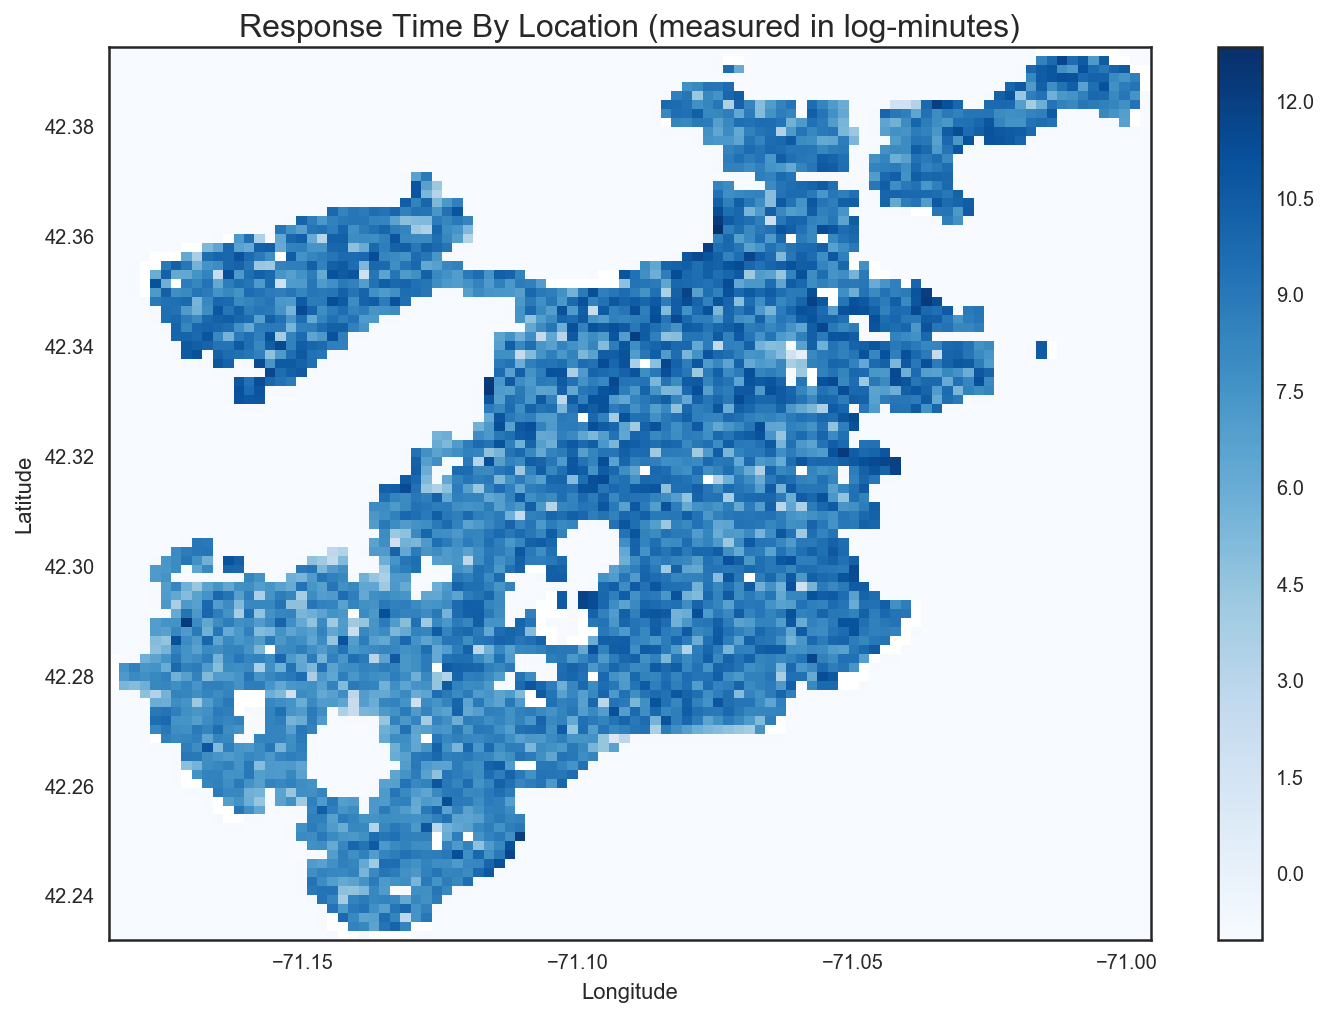

In [174]:
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Response Time By Location (measured in log-minutes)")
plt.imshow(grid_z0.T, 
           extent=(min(dat[:,0]),max(dat[:,0]),
                   min(dat[:,1]),max(dat[:,1])),
           origin='lower',
          cmap=plt.get_cmap('Blues'),
          interpolation='none')
plt.colorbar()

In [40]:
np.

In [59]:
mask = np.zeros([2,2])
print mask
print
for i in mask:
    print i

[[ 0.  0.]
 [ 0.  0.]]

[ 0.  0.]
[ 0.  0.]


In [ ]:
np.di